<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [ ]:
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers
from keras.applications import VGG19
from keras import models
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# # Mount Google Drive
# drive.mount('/content/drive')

# # Navigate to your folder
folder_path = '/content/drive/MyDrive/PlantVillage'




## 2. Loading our dataset.

In [ ]:
#loading the dataset
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(256, 256), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16031 files belonging to 10 classes.


In [ ]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


### Visualizing some of our images

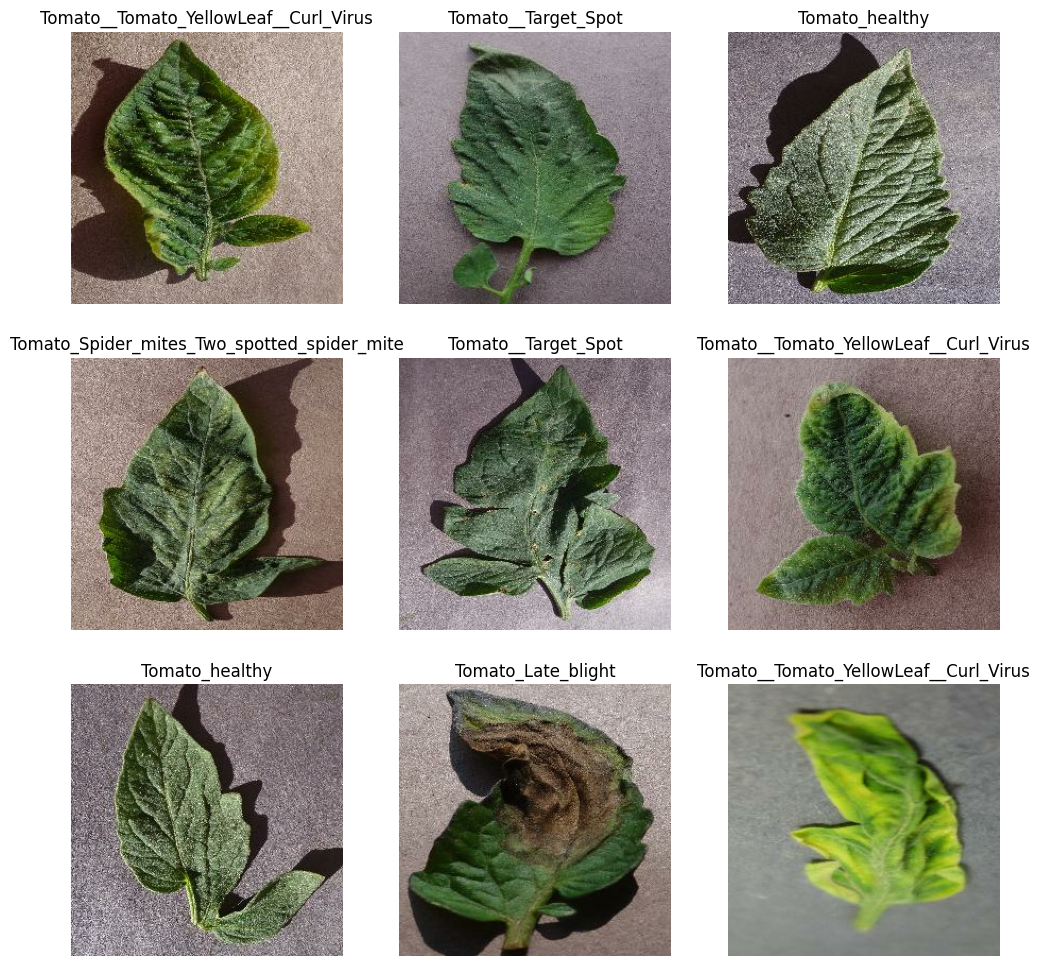

In [ ]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)


## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [ ]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [ ]:

# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

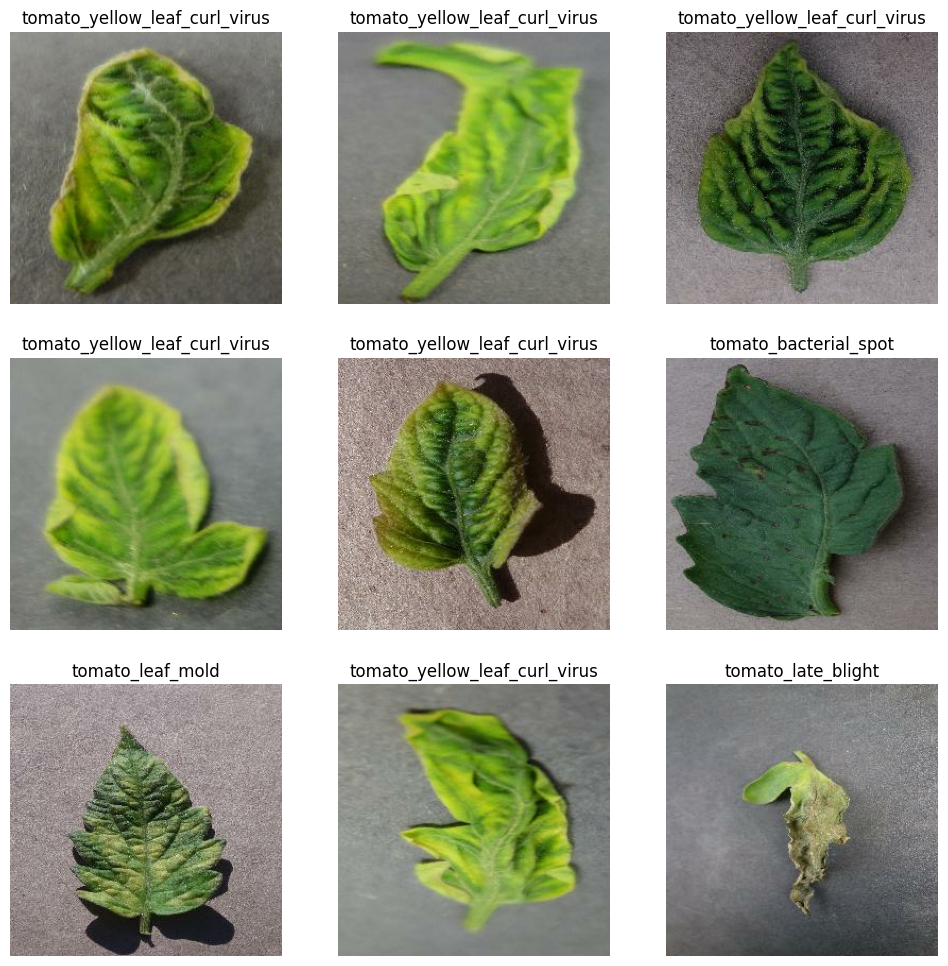

In [ ]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [ ]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [ ]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

**Class Distribution**

In [ ]:
# # A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1601, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1919, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


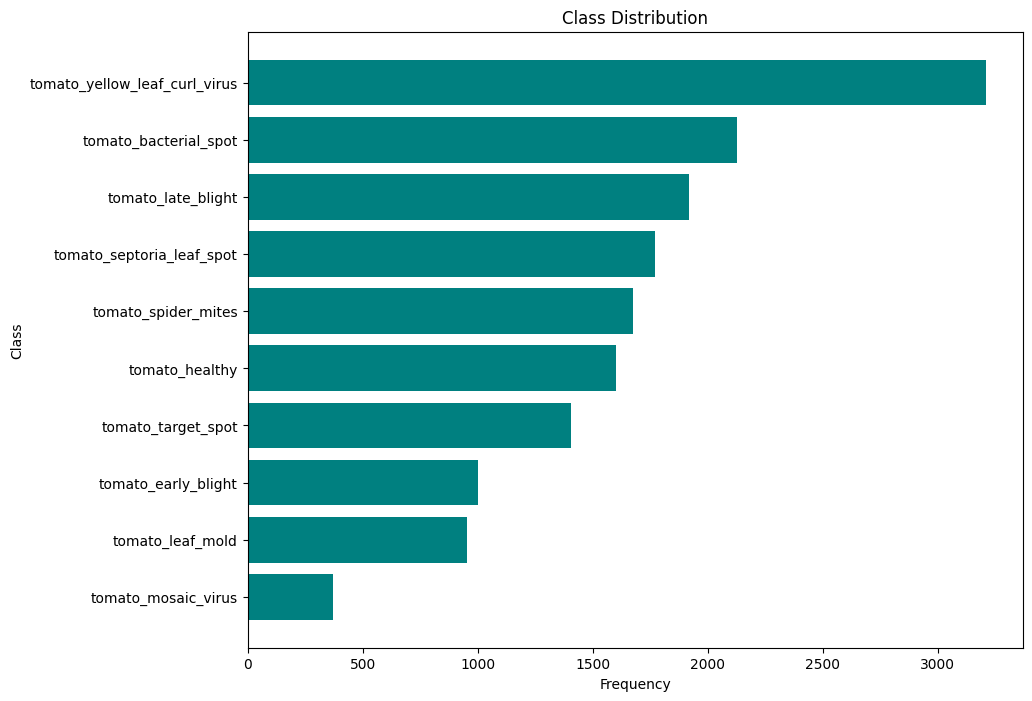

In [ ]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

# Data Preprocessing

**Splitting our data set**

In [ ]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set


In [ ]:
# Printing the length of our train, validation and test data
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

400
50
51


**Caching our data**

In [ ]:


train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Resizing, Rescaling and Augmentation**

In [ ]:
img_size = 256

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
                layers.Resizing(img_size,img_size),
                layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

In [ ]:
# Apply data augmentation to the training set only
def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_set = train_set.map(augment)

In [ ]:
# # Define the get_subset function if it's not defined elsewhere
# def get_subset(dataset, fraction):
#   """
#   Returns a subset of the given dataset.

#   Args:
#     dataset: The dataset to extract a subset from.
#     fraction: The fraction of the dataset to return.

#   Returns:
#     A subset of the original dataset.
#   """
#   subset_size = int(len(dataset) * fraction)
#   return dataset.take(subset_size)

# # Data Subset
# train_subset = get_subset(train_set, 1/3)
# val_subset = get_subset(val_set, 1/3)
# test_subset = get_subset(test_set, 1/3)


### **Base Model: Convolutional Neural Network**
- We have selected CNN as our baselline model sicne it is not computationally expensive and has the ability to capture spatial hierarchies in imaes through convolutional layers.

In [ ]:
#Sequential model

model_c = models.Sequential([
    resize_and_rescale, #normalizes pixel values and ensuring consistent input size.
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25), # reduces overfitting through regularization
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])


In [ ]:
model_c.build(input_shape = (32,256,256,3))

In [ ]:
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

- The CNN model consists of 5 convolutional blocks each followed by a maxpooling and a dropout  layer for downsampling and regularization. The model's depth enables hierarchical feature extraction, ending with a flatten layer and two dense layers for classification.

In [ ]:
#import earlystopping
from tensorflow.keras.callbacks import EarlyStopping
# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# compiling the model with the Adam optimizer , cateegorical crossentropy loss and accuracy metric
model_c.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)
# training the model on the training set
history_c = model_c.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
400/400 [==============================] - 209s 518ms/step - loss: 0.3869 - accuracy: 0.8670 - val_loss: 0.8630 - val_accuracy: 0.7487
Epoch 2/50
400/400 [==============================] - 207s 516ms/step - loss: 0.3602 - accuracy: 0.8750 - val_loss: 0.8228 - val_accuracy: 0.7550
Epoch 3/50
400/400 [==============================] - 204s 510ms/step - loss: 0.3288 - accuracy: 0.8849 - val_loss: 0.3902 - val_accuracy: 0.8625
Epoch 4/50
400/400 [==============================] - 205s 511ms/step - loss: 0.2975 - accuracy: 0.8950 - val_loss: 0.4090 - val_accuracy: 0.8575
Epoch 5/50
400/400 [==============================] - 207s 516ms/step - loss: 0.2907 - accuracy: 0.8973 - val_loss: 0.7033 - val_accuracy: 0.8019
Epoch 6/50
400/400 [==============================] - 206s 514ms/step - loss: 0.2612 - accuracy: 0.9119 - val_loss: 0.2519 - val_accuracy: 0.9087
Epoch 7/50
400/400 [==============================] - 204s 510ms/step - loss: 0.2431 - accuracy: 0.9135 - val_loss: 0.6450 -

In [ ]:
# function to plot training history

def plot_training_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


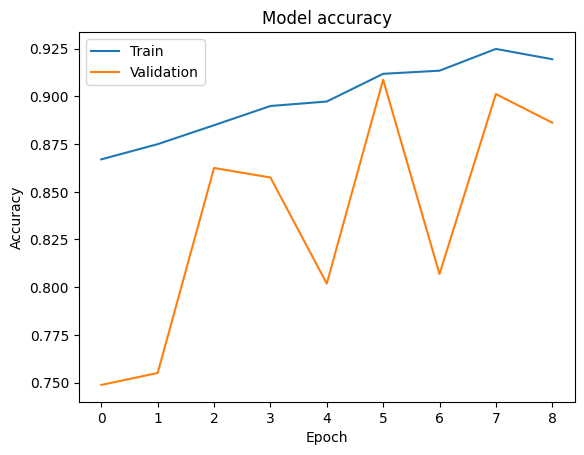

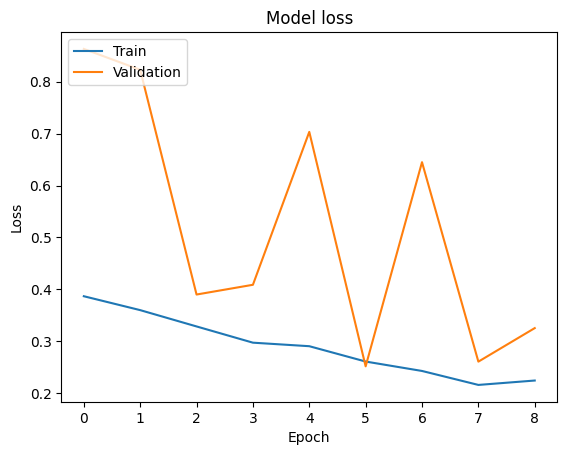

In [ ]:
plot_training_history(history_c)

### **Observations**
- The training accuracy increases steadily as the number of epochs increase meaning the modle is learning well to the training data.
- The validation accuracy increases initially as the number of epochs increase however, the there is some fluctuations indicatiting a little bit of overfitting meaning the model fits training data well than validation data.
- The training loss decreases as the number of epochs increase.
- The validation loss shows significant fluctuations as the number of epochs decrease indiicating inconsistent performance on the vakidation set

In [ ]:
test_loss, test_acc = model_c.evaluate(test_set)#evaluating the model on the test data
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

51/51 [==============================] - 29s 97ms/step - loss: 0.2781 - accuracy: 0.9001
Test accuracy: 0.90
Test loss: 0.28


In [ ]:
# Generate predictions for the test set
predictions = model_c.predict(test_set)

# Assuming test_set has labels and batch size for unpacking
true_labels = []
predicted_labels = []
batch_size = 32  # or any batch size you used in your test set

for images, labels in test_set:
    preds = model_c.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(preds, axis=1))

# Display a sample of predictions
for i in range(10):  # show 10 sample predictions
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")

1/1 [==============================] - 0s 127ms/step
True label: 6, Predicted label: 5
True label: 2, Predicted label: 2
True label: 2, Predicted label: 2
True label: 4, Predicted label: 4
True label: 5, Predicted label: 5
True label: 5, Predicted label: 5
True label: 9, Predicted label: 9
True label: 5, Predicted label: 5
True label: 6, Predicted label: 5
True label: 6, Predicted label: 6


- Out of 10 samples, the model made 8 correct predictions and 2 incorrect predictions.
- The model shows a difficulty distinguishing between classes 6 and 5. This suggests that the features distinguishing these two classes may be similar, causing confusion during prediction.
- While the model performs well overall, it struggles to differentiate between certain classes.

In [ ]:
# save model in keras

model_c.save('cnnbase_model.keras')


In [ ]:
history_c.history

{'loss': [0.3869115114212036,
  0.36015790700912476,
  0.328750342130661,
  0.2975032329559326,
  0.290713906288147,
  0.26117458939552307,
  0.24305665493011475,
  0.21617333590984344,
  0.22462566196918488],
 'accuracy': [0.867020845413208,
  0.8749902248382568,
  0.88491290807724,
  0.8949918150901794,
  0.8973357081413269,
  0.9118680953979492,
  0.9135088920593262,
  0.9249160289764404,
  0.9195249676704407],
 'val_loss': [0.8630133271217346,
  0.8228091597557068,
  0.39018404483795166,
  0.40895164012908936,
  0.7032987475395203,
  0.25194263458251953,
  0.6449519395828247,
  0.2609870135784149,
  0.32554927468299866],
 'val_accuracy': [0.7487499713897705,
  0.7549999952316284,
  0.862500011920929,
  0.8575000166893005,
  0.8018749952316284,
  0.9087499976158142,
  0.8068749904632568,
  0.9012500047683716,
  0.8862500190734863]}

In [ ]:
#Recording History in json
import json
with open('history_cnn.json','w') as f:
  json.dump(history_c.history,f)

### Model 2: VGG19 pretrained network model
- Onto our next model we will use VGG19 which is oftenly used a pretrained network  model on larger datasets. This  will allow us to extract features effectively from our images and improve on our baseline model.

In [ ]:
# Initialize Base
from keras.applications import VGG19
from keras import models # Import the models class
from keras import layers # Import the layers class
# Initialize Base
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
# Define Model Architecture
model2 = models.Sequential()
model2.add(cnn_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

cnn_base.trainable=False #freeze the base model to prevent the pretrained weights from being updated during training

for layer in model2.layers:
  print(layer.name, layer.trainable)

# check how many trainable weights are in the model
print(len(model2.trainable_weights))

model2.summary()

80134624/80134624 [==============================] - 1s 0us/step
vgg19 False
flatten True
dense True
dense_1 True
dense_2 True
dense_3 True
dense_4 True
10
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 64)                2097216   
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Defining the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor ='val_accuracy',  # Monitor validation accuracy
    patience = 3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
model2.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
400/400 [==============================] - 456s 1s/step - loss: 1.0405 - accuracy: 0.6723 - val_loss: 0.6819 - val_accuracy: 0.7769
Epoch 2/50
400/400 [==============================] - 398s 995ms/step - loss: 0.5632 - accuracy: 0.8100 - val_loss: 0.4761 - val_accuracy: 0.8525
Epoch 3/50
400/400 [==============================] - 394s 985ms/step - loss: 0.4505 - accuracy: 0.8519 - val_loss: 0.4189 - val_accuracy: 0.8581
Epoch 4/50
400/400 [==============================] - 397s 993ms/step - loss: 0.3891 - accuracy: 0.8685 - val_loss: 0.3801 - val_accuracy: 0.8737
Epoch 5/50
400/400 [==============================] - 394s 984ms/step - loss: 0.3506 - accuracy: 0.8862 - val_loss: 0.5239 - val_accuracy: 0.8350
Epoch 6/50
400/400 [==============================] - 394s 983ms/step - loss: 0.3334 - accuracy: 0.8862 - val_loss: 0.3468 - val_accuracy: 0.8913
Epoch 7/50
400/400 [==============================] - 394s 984ms/step - loss: 0.3079 - accuracy: 0.8955 - val_loss: 0.3420 - va

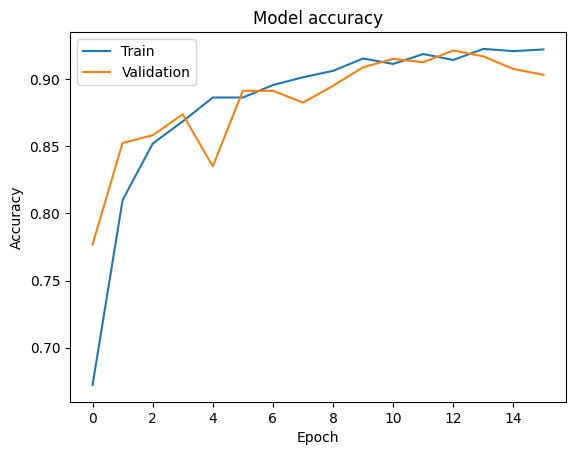

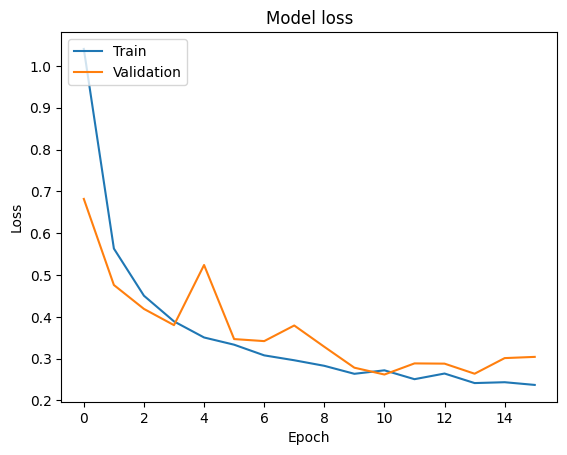

In [ ]:

plot_training_history(history2)

### Observations
- The training accuracy increases steadily as the number of epochs increase meaning the modle is learning well to the training data.
- The validation accuracy increases initially as the number of epochs increase however, the there is still some fluctuations indicatiting a little bit of overfitting.
- The training loss decreases as the number of epochs increase.
- The validation loss shows a few fluctuations as the number of epochs decrease indicating inconsistent performance on the vakidation set.
- The Overall perfomance of the model is etterr than our CNN model since oyur validation sets have showwed improvement in the fluctuaions indicating the model is able to generalize better.

In [ ]:
test_loss, test_acc = model2.evaluate(test_set)
print(f'Test accuracy: {test_acc:.2f}')
print(f'Test loss: {test_loss:.2f}')

51/51 [==============================] - 69s 874ms/step - loss: 0.2604 - accuracy: 0.9234
Test accuracy: 0.92
Test loss: 0.26


- The loss of 0.2604 indicates how well the model’s predictions are matching the true labels. Lower loss values generally signify better model performance. The accuracy of 92.34% indicates that the model correctly predicted the labels for about 92.34% of the training samples

In [ ]:
history2.history

{'loss': [1.040506362915039,
  0.5632164478302002,
  0.45046499371528625,
  0.38907602429389954,
  0.35064995288848877,
  0.3333839774131775,
  0.3079037368297577,
  0.29618212580680847,
  0.2828966975212097,
  0.2637879550457001,
  0.2721295654773712,
  0.25093328952789307,
  0.26444485783576965,
  0.24165166914463043,
  0.24368080496788025,
  0.2372240573167801],
 'accuracy': [0.672318160533905,
  0.8099851608276367,
  0.8519415855407715,
  0.8685053586959839,
  0.8862411379814148,
  0.8862411379814148,
  0.8955386877059937,
  0.9013203978538513,
  0.9060863852500916,
  0.9153059124946594,
  0.9112430810928345,
  0.9185873866081238,
  0.9142120480537415,
  0.9224157929420471,
  0.9207750558853149,
  0.9220251441001892],
 'val_loss': [0.6819299459457397,
  0.4761236310005188,
  0.4189297556877136,
  0.3801201581954956,
  0.5239443182945251,
  0.3468082547187805,
  0.34198111295700073,
  0.379288911819458,
  0.32838863134384155,
  0.27840960025787354,
  0.2620820701122284,
  0.28866860

In [ ]:
#Recording History in json
import json
with open('history_VGG19.json','w') as f:
  json.dump(history2.history,f)

In [ ]:
#saving model3 with keras

model2.save('VGG19.keras')


In [ ]:
# Generate predictions for the test set
predictions = model2.predict(test_set)

# Assuming test_set has labels and batch size for unpacking
true_labels = []
predicted_labels = []
batch_size = 32  # or any batch size you used in your test set

for images, labels in test_set:
    preds = model2.predict(images)
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(preds, axis=1))

# Display a sample of predictions
for i in range(10):  # show 10 sample predictions
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")

1/1 [==============================] - 1s 869ms/step
True label: 5, Predicted label: 5
True label: 0, Predicted label: 0
True label: 9, Predicted label: 9
True label: 4, Predicted label: 6
True label: 5, Predicted label: 5
True label: 4, Predicted label: 4
True label: 4, Predicted label: 4
True label: 2, Predicted label: 2
True label: 9, Predicted label: 9
True label: 9, Predicted label: 9



- The model correctly predicted 9 out of 10 labels in this sample. The only incorrect prediction was where the true label was 4, but the model predicted 6. This indicates that the model is performing well, with a high accuracy in this sample, but there is room for improvement, especially in distinguishing between classes that might be similar or have overlapping features.